In [1]:
#Exploratory analysis of selling electricity vs producing BTC from Wind Power
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [80]:
#Assumptions:
#Antminer 24/7 for a year it will produce about 0.85 bitcoins, at a cost of about 15,000 kilowatt hours. (Forbes)
btc_per_mwh = 0.05 #approx 0.05666 so 0.05 as rough estimate, calc from -> 0.85/15
avg_usdsek = 8
antminer_cost = 8200 #USD per antminer station, capable of producing 0.85 BTC per year @ 15 MWh

In [106]:
btc_data_filepath = "data/BTC_CoinDesk.csv"
power_data_filepath = 'data/Power_Market_Data_11_16_shifted.csv' #Proxy data by shifting 11-16 data 3 years ahead

In [107]:
0.05*40000

2000.0

In [108]:
#Read BTC data from file
delim1 = ","
btcdata = pd.read_csv(btc_data_filepath, sep=delim1)
btcdata["Date"] = pd.DataFrame([x[0:10] for x in btcdata["date_UTC"]])
btcdata=btcdata.dropna()
btcdata["price_SEK"] = btcdata["price_USD"]*avg_usdsek
btcdata["exp_output_per_mwh_SEK"] = btcdata["price_USD"]*avg_usdsek*btc_per_mwh
btcdata.head()

,currency,date_UTC,price_USD,Date,price_SEK,exp_output_per_mwh_SEK
0,BTC,2013-10-01T00:00:00Z,123.25983,2013-10-01,986.07864,49.303932
1,BTC,2013-10-02T00:00:00Z,125.58083,2013-10-02,1004.64664,50.232332
2,BTC,2013-10-03T00:00:00Z,100.81083,2013-10-03,806.48664,40.324332
3,BTC,2013-10-04T00:00:00Z,116.96700,2013-10-04,935.73600,46.786800
4,BTC,2013-10-05T00:00:00Z,121.17883,2013-10-05,969.43064,48.471532


In [109]:
#Read Power Market Data from file
delim2 = ";"
powerdata = pd.read_csv(power_data_filepath,sep=delim2)
#powerdata = powerdata.dropna()
powerdata.head()

,Date,Month,Day,Hour,SYS,SE1,SE2,SE3,SE4,DEMAND,...,Heat_other,Unspec,Sun,SUPPLY,IMPORT,Temp,No_hydro,SE_hydro,FI_hydro,Week
0,2014-01-02,1,7,1,NaN,NaN,NaN,778.95,NaN,-16488.845760,...,1878.390502,1.3743,0.003,15449.309282,1038.7297,-3.5,NaN,NaN,NaN,NaN
1,2014-01-02,1,7,2,NaN,NaN,NaN,746.01,NaN,-16337.272125,...,1920.229341,1.3404,0.002,15323.503929,1013.0168,-3.7,NaN,NaN,NaN,NaN
2,2014-01-02,1,7,3,NaN,NaN,NaN,734.46,NaN,-16329.520536,...,1949.179294,1.3478,0.003,15449.399052,879.4224,-3.7,NaN,NaN,NaN,NaN
3,2014-01-02,1,7,4,NaN,NaN,NaN,738.57,NaN,-16466.559913,...,1940.648825,1.3537,0.002,15470.430006,994.9617,-3.7,NaN,NaN,NaN,NaN
4,2014-01-02,1,7,5,NaN,NaN,NaN,741.44,NaN,-16643.678798,...,1928.890902,1.4186,0.003,15411.277566,1231.5175,-3.9,NaN,NaN,NaN,NaN


In [110]:
#Create new dataframe from daily averages in power data, and daily avg BTC
pdata = powerdata[["Date","SE3","Wind","Day","Month","Temp"]]
df = pdata.groupby("Date",as_index=False).mean()
df.head()

,Date,SE3,Wind,Day,Month,Temp
0,2014-01-02,779.749130,597.241374,7,1,-3.895652
1,2014-01-03,808.505417,300.913565,1,1,-6.758333
2,2014-01-04,799.733333,347.197289,2,1,-6.445833
3,2014-01-05,763.241250,644.001771,3,1,-0.925000
4,2014-01-06,712.645833,871.104725,4,1,-1.070833


In [123]:
#Join data
btcdata.set_index("Date")
df.set_index("Date")
data = pd.merge(df, btcdata, on='Date', how="inner")
data = data[["Date","SE3","Wind","price_USD","price_SEK","exp_output_per_mwh_SEK","Month","Day","Temp"]]
data["BTCoutput_SE3_spread"] = data["exp_output_per_mwh_SEK"] - data["SE3"]
data.head()

,Date,SE3,Wind,price_USD,price_SEK,exp_output_per_mwh_SEK,Month,Day,Temp,BTCoutput_SE3_spread
0,2014-01-02,779.749130,597.241374,769.27216,6154.17728,307.708864,1,7,-3.895652,-472.040266
1,2014-01-03,808.505417,300.913565,814.74112,6517.92896,325.896448,1,1,-6.758333,-482.608969
2,2014-01-04,799.733333,347.197289,828.96166,6631.69328,331.584664,1,2,-6.445833,-468.148669
3,2014-01-05,763.241250,644.001771,859.19000,6873.52000,343.676000,1,3,-0.925000,-419.565250
4,2014-01-06,712.645833,871.104725,938.09999,7504.79992,375.239996,1,4,-1.070833,-337.405837


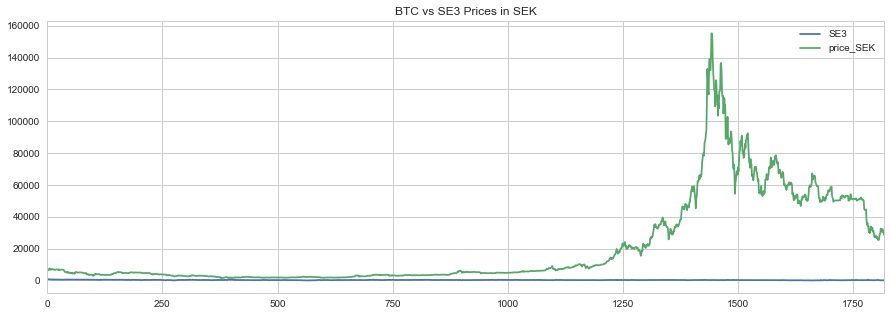

In [112]:
plotdata=data[["Date","SE3","price_SEK"]]
plotdata.set_index("Date")
plt.figure()
plotdata.plot(use_index=True,figsize=(15,5), title="BTC vs SE3 Prices in SEK")

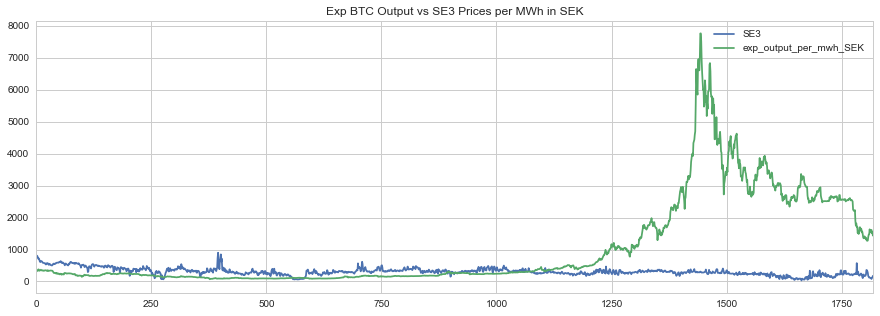

In [113]:
plotdata=data[["Date","SE3","exp_output_per_mwh_SEK"]]
plotdata.set_index("Date")
plt.figure()
plotdata.plot(use_index=True,figsize=(15,5), title="Exp BTC Output vs SE3 Prices per MWh in SEK")

In [131]:
sns.jointplot(data=plotdata)

TypeError: jointplot() missing 2 required positional arguments: 'x' and 'y'

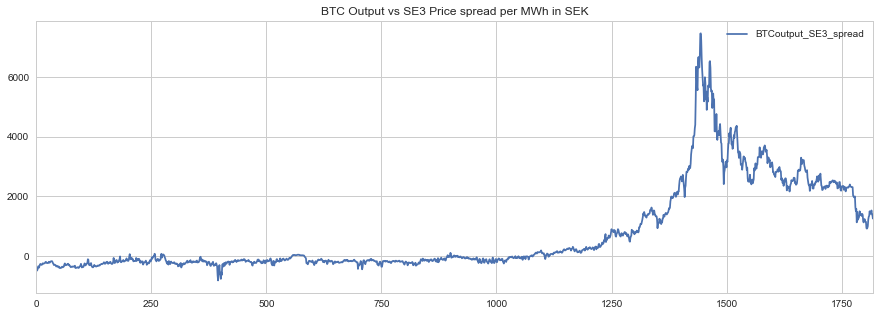

In [124]:
plotdata=data[["Date","BTCoutput_SE3_spread"]]
plt.figure()
plotdata.plot(use_index=True,figsize=(15,5), title="BTC Output vs SE3 Price spread per MWh in SEK")

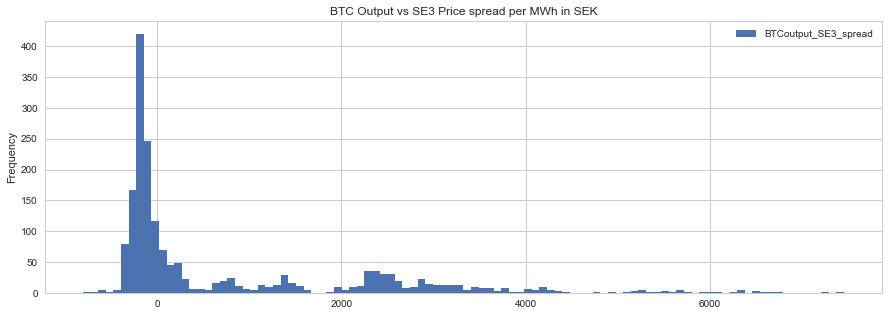

In [127]:
plotdata.plot(kind="hist",bins=100,use_index=True,figsize=(15,5), title="BTC Output vs SE3 Price spread per MWh in SEK")

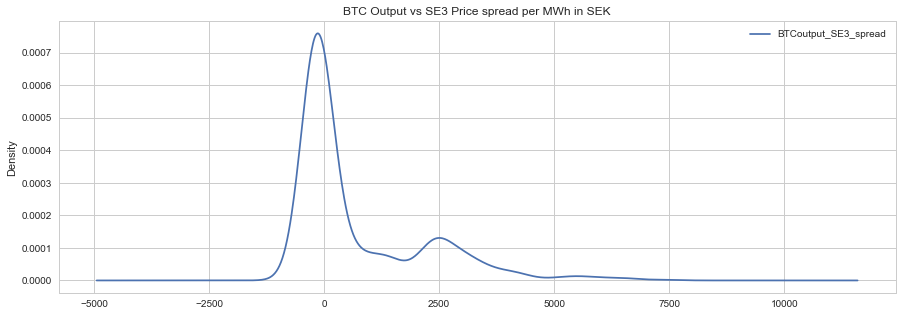

In [128]:
plotdata.plot(kind="kde",use_index=True,figsize=(15,5), title="BTC Output vs SE3 Price spread per MWh in SEK")

In [130]:
#Realized sum of the spread, implies gain from producing BTC over the period as opposed to Electricity and selling in SE3
np.mean(plotdata["BTCoutput_SE3_spread"]) #Avg SEK per MWh "produced"

719.6447995188353